## **Audio to text - DAT301m - Data Processing**

### **1. Import required libraries**

#### *Note: librosa==0.11.0*

In [31]:
import os
import random
import numpy as np

import pandas as pd

import tensorflow as tf

from IPython.display import Audio

import matplotlib.pyplot as plt
import librosa
import librosa.display

### **2. Audio processing**

#### First we have to download the audio files and load them using the Audio library and the librosa library:

#### Download link: https://www.kaggle.com/datasets/kynthesis/vivos-vietnamese-speech-corpus-for-asr/data

In [ ]:
train_audio_path = 'D:\\Audio2Text\\vivos\\train\\waves'  # Replace with your actual folder name
test_audio_path = 'D:\\Audio2Text\\vivos\\test\\waves'    # Replace with your actual folder name

In [3]:
train_wavs = []
for root, dirs, files in os.walk(train_audio_path):
    for file in files:
        if file.endswith('.wav'):
            train_wavs.append(os.path.join(root, file))

print(f"Total .wav files found in folder \"train\": {len(train_wavs)}")
print("----------------------------------")
print(train_wavs[:5])

Total .wav files found in folder "train": 11660
----------------------------------
['D:\\Audio2Text\\vivos\\train\\waves\\VIVOSSPK01\\VIVOSSPK01_R001.wav', 'D:\\Audio2Text\\vivos\\train\\waves\\VIVOSSPK01\\VIVOSSPK01_R002.wav', 'D:\\Audio2Text\\vivos\\train\\waves\\VIVOSSPK01\\VIVOSSPK01_R003.wav', 'D:\\Audio2Text\\vivos\\train\\waves\\VIVOSSPK01\\VIVOSSPK01_R004.wav', 'D:\\Audio2Text\\vivos\\train\\waves\\VIVOSSPK01\\VIVOSSPK01_R005.wav']


In [4]:
test_wavs = []
for root, dirs, files in os.walk(test_audio_path):
    for file in files:
        if file.endswith('.wav'):
            test_wavs.append(os.path.join(root, file))

print(f"Total .wav files found in folder \"test\": {len(test_wavs)}")
print("----------------------------------")
print(test_wavs[:5])

Total .wav files found in folder "test": 760
----------------------------------
['D:\\Audio2Text\\vivos\\test\\waves\\VIVOSDEV01\\VIVOSDEV01_R002.wav', 'D:\\Audio2Text\\vivos\\test\\waves\\VIVOSDEV01\\VIVOSDEV01_R003.wav', 'D:\\Audio2Text\\vivos\\test\\waves\\VIVOSDEV01\\VIVOSDEV01_R012.wav', 'D:\\Audio2Text\\vivos\\test\\waves\\VIVOSDEV01\\VIVOSDEV01_R027.wav', 'D:\\Audio2Text\\vivos\\test\\waves\\VIVOSDEV01\\VIVOSDEV01_R028.wav']


#### Now we need to check the duration of each .wav file in the dataset. This will be important in the future:

In [27]:
def visualize_duration(list=None):
    '''
    Draw a histogram of audio duration of all files in a folder.

    Argument: list - specify the list of .wav files to be visualized.
                + Use list=train_wavs for train data
                + Use list=test_wavs for test data
    '''
    durations = []
    for wav_path in list:
        y, sr = librosa.load(wav_path, sr=None)
        duration = librosa.get_duration(y=y, sr=sr)
        durations.append(duration)

    plt.figure(figsize=(10, 5))
    plt.hist(durations, bins=30, color='pink', edgecolor='black')
    plt.xlabel('Duration (seconds)')
    plt.ylabel('Number of files')
    plt.title('Histogram of Audio File Durations in dataset')
    plt.show()

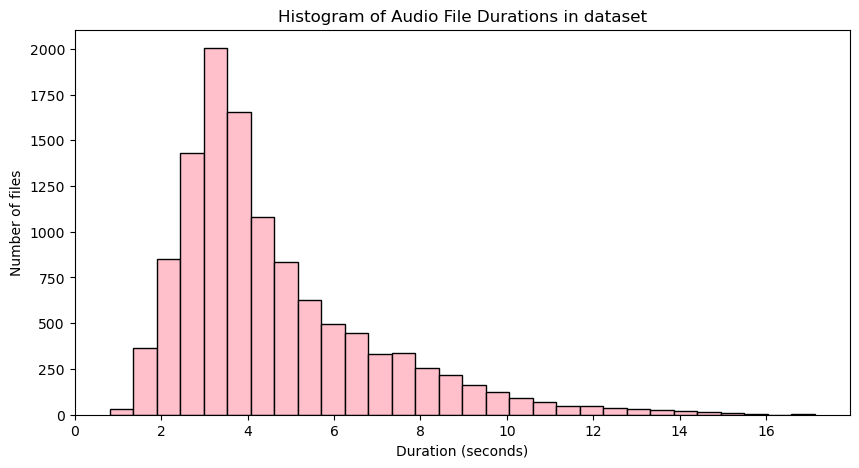

In [28]:
visualize_duration(train_wavs)

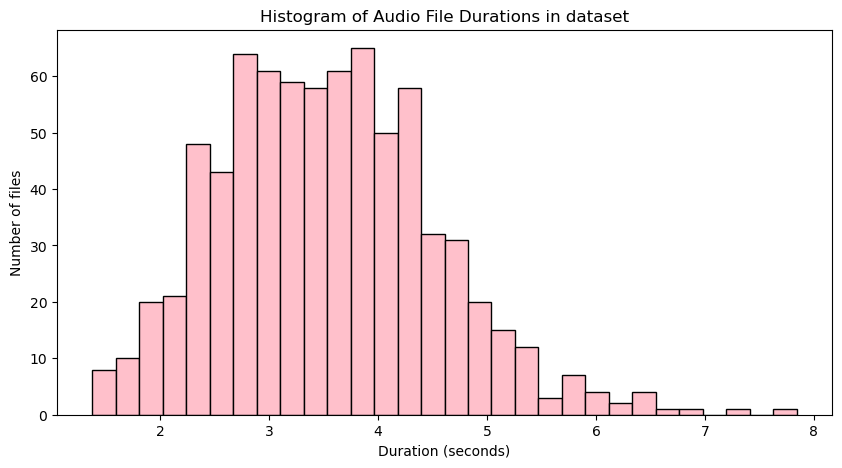

In [29]:
visualize_duration(test_wavs)

#### The datasets consist of mostly audio files with duration of 4 seconds or less. We should set the segment durations to 5 seconds when processing them.

#### Let's visualize an audio file:

In [5]:
def visualize_audio(path = None):
    '''
    Visualize an audio file from the train_wavs list.

    Argument: path - select a .wav file using the path specified. If left empty, randomly selects 
    a file from the list train_wavs to visualize.
    '''
    if path == None:
        choice = random.randint(0, len(train_wavs))
        path = train_wavs[choice]

    y, sr = librosa.load(path)

    plt.figure(figsize=(14, 5), frameon=True)
    librosa.display.waveshow(y, sr=sr)
    plt.title(f"Waveform of file {path}")
    plt.show()

    return None

c:\ProgramData\anaconda3\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
c:\ProgramData\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
c:\ProgramData\anaconda3\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


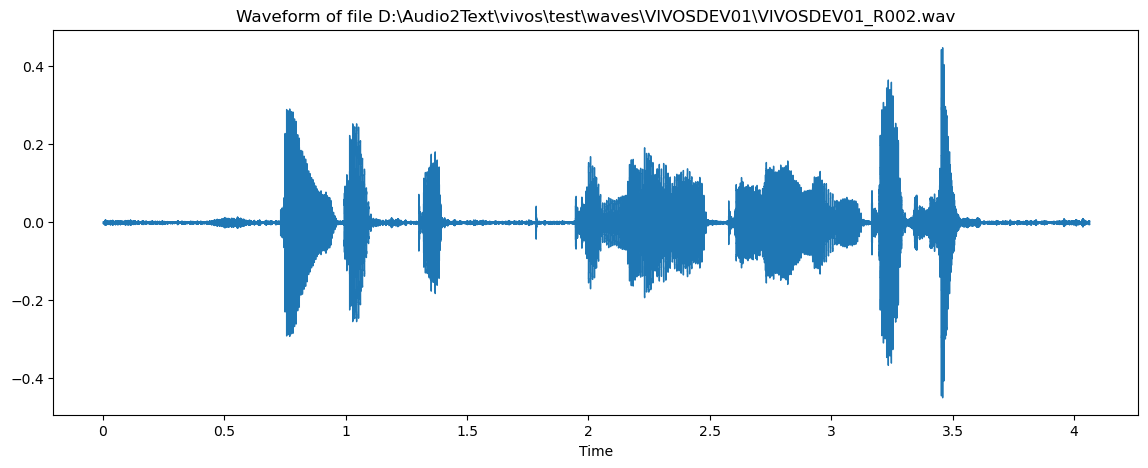

In [6]:
visualize_audio('D:\\Audio2Text\\vivos\\test\\waves\\VIVOSDEV01\\VIVOSDEV01_R002.wav')

#### Let's try to listen to the corresponding audio file:

In [7]:
Audio('D:\\Audio2Text\\vivos\\test\\waves\\VIVOSDEV01\\VIVOSDEV01_R002.wav')

#### Now we will try to process the audio files using the following steps:

1. Convert to Mono
- Most ASR models expect mono audio.
- Use librosa.load(path, mono=True) (default is mono).

2. Resample to 16kHz
- 16kHz is a common sample rate for speech models.
- Use librosa.load(path, sr=16000) to resample on load.

3. Normalize the audio
- Normalize the audio waveform (mean = 0, std = 1) before extracting MFCCs.

4. Split into Fixed-Length Segments
- Splitting into 5-second chunks is good for batching and training.
- Pad shorter segments with zeros (silence) using np.pad.

5. Extract MFCCs
- MFCCs are widely used features for speech recognition.
- Use librosa.feature.mfcc(y, sr, n_mfcc=13).

In [8]:
def process_audio(path, sr=16000, duration=5, n_mfcc=13, save_csv=False, csv_path=None):
    '''
    Process an audio file using its path.

    Arguments:
        + sr = 16000: Resample audio to 16kHz.
        + duration = 5: Split audio into 5-second segments. Pad if shorter.
        + n_mfcc = 13: Number of MFCCs.
        + save_csv (bool): If True, save MFCCs to CSV.
        + csv_path (path): Path to save the CSV file.
    '''
    # Load audio as mono and resample
    y, _ = librosa.load(path, sr=sr, mono=True)

    # Pad or trim to fixed length
    target_length = sr * duration
    if len(y) < target_length:
        y = np.pad(y, (0, target_length - len(y)))
    else:
        y = y[:target_length]

    # Normalize audio (zero mean, unit variance)
    if np.std(y) > 0:
        y = (y - np.mean(y)) / np.std(y)

    # Extract MFCCs
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)

    # Optionally save to CSV
    if save_csv and csv_path is not None:
        np.savetxt(csv_path, mfcc, delimiter=",")
        
    return mfcc

#### Apply MFCC extraction on the train dataset (.csv file is saved in the `train` folder):

#### Note: might take ~3 minutes to run this cell below

In [18]:
csv_output_folder = 'D:/Audio2Text/vivos/train/csv'  # Replace with your actual folder name
os.makedirs(csv_output_folder, exist_ok=True)

for file in train_wavs:
    base = os.path.splitext(os.path.basename(file))[0]  # e.g., VIVOSSPK01_R001
    csv_path = os.path.join(csv_output_folder, base + '_mfcc.csv')
    mfcc = process_audio(file, save_csv=True, csv_path=csv_path)

#### Apply MFCC extraction on the test dataset (.csv file is saved in the `test` folder):

In [19]:
csv_output_folder = 'D:/Audio2Text/vivos/test/csv'  # Replace with your actual folder name
os.makedirs(csv_output_folder, exist_ok=True)

for file in test_wavs:
    base = os.path.splitext(os.path.basename(file))[0]  # e.g., VIVOSSPK01_R001
    csv_path = os.path.join(csv_output_folder, base + '_mfcc.csv')
    mfcc = process_audio(file, save_csv=True, csv_path=csv_path)

#### Visualizing time!!

In [20]:
def visualize_mfcc(csv_path):
    mfcc = np.loadtxt(csv_path, delimiter=",")
    plt.figure(figsize=(10, 4))
    plt.imshow(mfcc, aspect='auto', origin='lower', cmap='viridis')
    plt.title(f"MFCCs from {csv_path}")
    plt.xlabel("Frame")
    plt.ylabel("MFCC Coefficient")
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.show()

In [32]:
pd.read_csv('D:\\Audio2Text\\vivos\\train\\csv\\VIVOSSPK01_R002_mfcc.csv')

,-2.296114807128906250e+02,-2.005900115966796875e+02,-1.926770172119140625e+02,-1.929310455322265625e+02,-1.909714813232421875e+02,-1.886456909179687500e+02,-1.870785369873046875e+02,-1.865633697509765625e+02,-1.896510467529296875e+02,-1.927446136474609375e+02,...,-1.938841705322265625e+02,-1.996332855224609375e+02,-2.010083923339843750e+02,-1.916060333251953125e+02,-1.846144714355468750e+02,-1.933973236083984375e+02,-1.978936309814453125e+02,-2.105614776611328125e+02,-2.885718078613281250e+02,-3.645979614257812500e+02
0,54.946701,56.850437,61.322708,57.966908,62.389996,64.411430,62.116718,57.764671,51.683426,53.411781,...,64.301529,60.132095,58.242821,53.348385,53.122314,56.493141,58.302525,62.513744,56.685463,0.0
1,21.332520,22.467810,21.894524,20.799976,20.104639,22.226521,22.611263,18.493233,17.452267,15.032707,...,24.776964,22.863319,21.247183,20.850021,18.454155,15.572615,21.001190,23.477798,29.205376,0.0
2,35.223495,37.764084,33.622704,38.523598,38.781059,40.421562,42.768715,38.234314,41.396149,36.584778,...,38.218842,37.289234,37.901726,39.134747,38.653507,34.089630,34.785881,35.612175,26.148445,0.0
3,1.339888,-0.525165,1.483785,3.472063,2.180997,-0.536339,-3.864632,-5.218612,-4.126706,0.068242,...,0.214741,3.629370,3.213102,-5.591833,-9.916086,-6.943112,-3.836013,-2.150223,3.949944,0.0
4,15.856089,18.039471,22.669128,22.904751,22.675888,22.845394,21.477772,21.859682,20.872456,22.685211,...,26.140305,24.461697,21.682419,27.525112,28.422565,20.874437,17.092398,19.315990,16.035393,0.0
5,2.227190,4.381306,7.476781,4.956951,5.757561,6.676868,1.892015,3.146650,4.157252,1.458441,...,9.777067,6.432924,4.761492,2.045530,2.400134,2.601509,4.544372,4.675335,8.444496,0.0
6,8.433926,13.194120,13.127499,8.767553,6.288136,7.020470,5.381068,4.652781,7.932421,10.463644,...,15.341548,10.891105,13.737579,10.189585,7.185324,8.692293,11.900283,12.500553,8.858967,0.0
7,10.757943,15.551069,16.130087,13.452047,10.291153,10.549968,14.013067,10.770325,8.156448,7.673150,...,11.160197,10.598702,13.587223,17.071081,13.984097,14.351147,8.709227,10.233817,16.978064,0.0
8,6.379579,11.388361,14.056501,15.785133,12.029639,12.733942,13.700100,10.601235,10.328585,9.804998,...,10.547045,11.986252,15.848695,13.127008,7.370224,17.032909,14.439713,8.985995,5.250937,0.0
9,5.927308,6.686722,10.085966,8.766460,2.278253,3.684621,5.367904,4.317596,8.495735,11.419306,...,6.685895,9.770243,13.276434,14.108722,13.691494,14.609779,11.280056,5.731344,4.805161,0.0


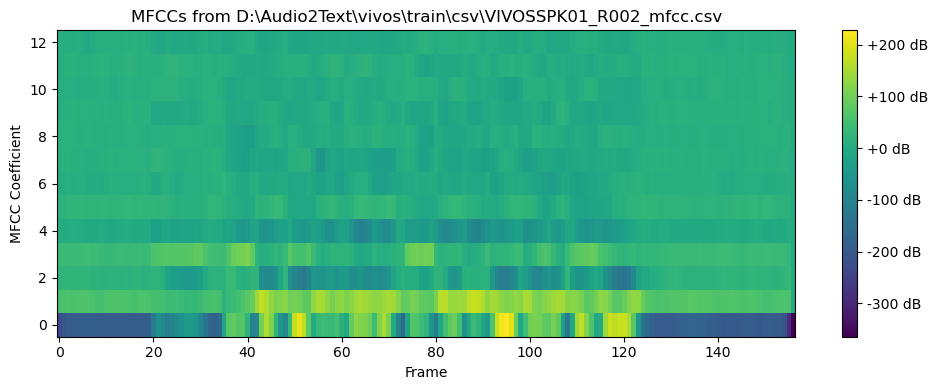

In [22]:
visualize_mfcc('D:\\Audio2Text\\vivos\\train\\csv\\VIVOSSPK01_R002_mfcc.csv')